In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import json
import difflib
import yfinance as yf
from sklearn.linear_model import LinearRegression

days_in_quarter = 63

In [2]:
# This part of the code is very ad-hoc, someone should clean it up---may be necessary to tweek data files to make it cleaner.

file_list = ['data\\S000006408.csv', 'data\\S000006409.csv', 'data\\S000006410.csv', 'data\\S000006411.csv', 'data\\S000006412.csv', 'data\\S000006413.csv', 'data\\S000006414.csv', 'data\\S000006415.csv', 'data\\S000006416.csv', 'data\\S000051152.csv', 'data\\S000062095.csv']
file_list = ['data\\S000006408.csv', 'data\\S000006409.csv', 'data\\S000006410.csv', 'data\\S000006411.csv', 'data\\S000006412.csv', 'data\\S000006413.csv', 'data\\S000006414.csv', 'data\\S000006415.csv', 'data\\S000006416.csv', 'data\\S000062095.csv']

series_to_ticker_mapping = {
    'S000006408': 'XLY',
    'S000006409': 'XLP',
    'S000006410': 'XLE',
    'S000006411': 'XLF',
    'S000006412': 'XLV',
    'S000006413': 'XLI',
    'S000006414': 'XLB',
    'S000006415': 'XLK',
    'S000006416': 'XLU',
    'S000051152': 'XLRE',
    'S000062095': 'XLC'
}

start_date = np.datetime64('2019-10-01')
end_date = np.datetime64('2024-04-01')

holdings_per_day = {}

for file_name in file_list:
    file_name = file_name.split('\\')[-1]
    series = file_name.split('.')[0]
    ticker = series_to_ticker_mapping[series]
    
    # Read the CSV
    df = pd.read_csv(f'data/{file_name}')
    df.index = df['Tickers']
    df = df.iloc[:,:3:-1]
    
    # This is an ad-hoc fix for the fact that some tickers are duplicated because the associated company name
    # label is not consistent (e.g. LOW in the ETF XLY)
    df = df.groupby(df.index).sum()
    
    df.columns = pd.to_datetime(df.columns)
    
    series_holdings_per_day = {}

    date_range = np.arange(start_date,end_date)

    for date in date_range:
        series_holdings_per_day[date] = df[df.columns[df.columns < date].max()]

    holdings_per_day[ticker] = pd.DataFrame(series_holdings_per_day).transpose() != 0
    
    holdings_per_day[ticker] = holdings_per_day[ticker].where(holdings_per_day[ticker] != 0,np.nan)


C:\Users\Bahar\AppData\Local\Temp\ipykernel_11908\4204126437.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(tickers))


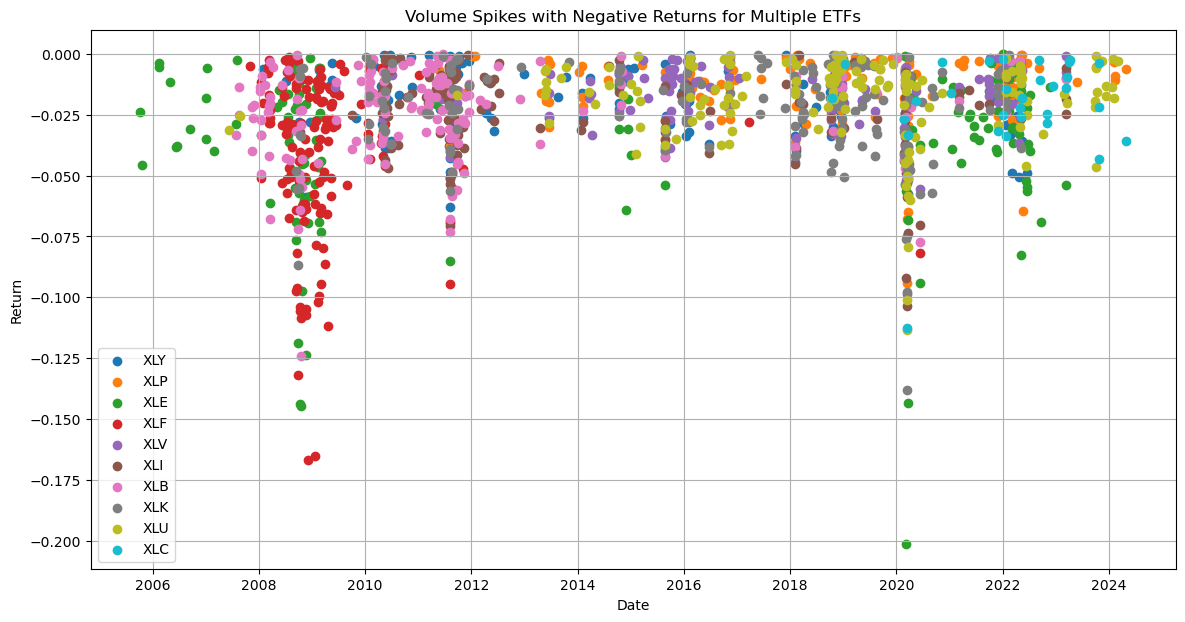

In [3]:

def volume_spikes(etf_ticker, threshold=2):
    data = yf.Ticker(etf_ticker).history(period='max')
    
    volume = data['Volume']
    mean_volume = volume.mean()
    std_volume = volume.std()
    
    spikes = volume[volume > mean_volume + threshold * std_volume]
    
    data['Return'] = data['Close'].pct_change()
    
    negative_return_spikes = spikes.index[data.loc[spikes.index, 'Return'] < 0]
    negative_returns = data.loc[negative_return_spikes, 'Return']
    
    return negative_returns

def plot_negative_returns_for_all_tickers(tickers, threshold=2):
    plt.figure(figsize=(14, 7))
    
    colors = plt.cm.get_cmap('tab10', len(tickers))

    for i, ticker in enumerate(tickers):
        negative_returns = volume_spikes(ticker, threshold)
        plt.scatter(negative_returns.index, negative_returns.values, color=colors(i), label=ticker)
    
    plt.title('Volume Spikes with Negative Returns for Multiple ETFs')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True)
    plt.show()

tickers = ['XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU', 'XLC']

plot_negative_returns_for_all_tickers(tickers)


In [4]:
def returns(ticker):
    data = yf.Ticker(ticker).history(period='max')
    returns = (data['Close'] - data['Close'].shift(1)) / data['Close'].shift(1)
    return returns

def log_returns(ticker):
    data = yf.Ticker(ticker).history(period='max')
    log_returns = np.log(data.Close / data.Close.shift(1))
    return log_returns

def betas(stock, etf, start_date, end_date, L_min=100, halflife=days_in_quarter):
    
    # L_min specifies how many days the stock must have been listed to calculate the beta coefficient.  
    # If the stock is quite newly listed, then the calculated beta value is unstable and not very meaningful 
    # (and so we will set beta = np.nan).  
    
    times = np.arange(start_date,end_date)#pd.date_range(start=start_date, end=end_date, freq='D')
    betas = []
    
    stock_returns = returns(stock)
    etf_returns = returns(etf)
    
    two_stocks = pd.DataFrame({stock: stock_returns, etf: etf_returns}).dropna()
    two_stocks.index = two_stocks.index.tz_localize(None)
    
    for t in times:
         
        # Include only columns through t-1 so that the beta on day t depends only on returns from before day t:
        
        etf_t = two_stocks.loc[:(t-1),etf].values.reshape(-1, 1)
        stock_t = two_stocks.loc[:(t-1),stock].values

        L = len(stock_t)
        
        alpha = 0.5 ** (1 / halflife)
        
        # Calculate exponentially decaying weights for linear regression, so that we weight more 
        # recent returns more heavily.
        
        weights = alpha ** (L - 1 - np.arange(L))
        weights /= weights.sum()
        
        # Compute regression coefficient beta, which measures how much the stock returns 
        # are expected to move in response to ETF returns.  Stocks in an ETF with larger betas
        # contribute more to the volatility of the ETF.  Intuitively, stocks with smaller beta
        # values are likely less related to the themes surrounding most high-volume selloffs of the ETF.
              
        model = LinearRegression()
        
        if L > L_min:
            model.fit(etf_t, stock_t, sample_weight=weights)
            beta = model.coef_[0]
        else:
            beta = np.nan
        
        betas.append(beta)
    
    return pd.Series(data = betas, index = times)

Note that a beta value of np.nan can mean two different things: 
(1) The stock wasn't part of the ETF that quarter.
(2) The stock was too newly listed to get a robust beta value.

In [5]:
holdings_per_day['XLV'].columns

Index(['A', 'ABBV', 'ABT', 'ALGN', 'ALLE', 'AMGN', 'BAX', 'BDX', 'BIIB', 'BIO',
       'BMY', 'BSX', 'CAH', 'CI', 'CIEN', 'CNC', 'COO', 'COR', 'CRL', 'CTLT',
       'CVS', 'DGX', 'DHR', 'DVA', 'DXCM', 'ELV', 'EW', 'GEHC', 'GILD', 'HCA',
       'HOLX', 'HSIC', 'HUM', 'IDXX', 'ILMN', 'INCY', 'IQV', 'ISRG', 'JNJ',
       'LH', 'LLY', 'LXRX', 'MCK', 'MDT', 'MMSI', 'MOH', 'MRK', 'MRNA', 'MTD',
       'NKTR', 'OGN', 'PFE', 'PODD', 'PRGO', 'QBIO', 'REGN', 'RMD', 'RVTY',
       'STE', 'STT', 'SYK', 'TECH', 'TFX', 'TMO', 'TRP', 'UHS', 'UNH', 'VRTX',
       'VTRS', 'WAT', 'WHSI', 'WST', 'XRAY', 'YNDX', 'ZBH', 'ZTS'],
      dtype='object', name='Tickers')

In [6]:
# betas_per_day = {}

for etf in holdings_per_day.keys():
    print(etf)
    print(holdings_per_day[etf].columns)
    df = holdings_per_day[etf]
#     betas_per_day[etf] = pd.DataFrame({stock: betas(stock,etf,start_date,end_date) * df[stock] for stock in df.columns})
    betas_per_day = pd.DataFrame({stock: betas(stock,etf,start_date,end_date) * df[stock] for stock in df.columns})
    
    df = pd.DataFrame(betas_per_day)
    df.to_csv(f'data/{etf}_betas_per_day.csv')
    

XLY
Index(['AAP', 'ABNB', 'AMZN', 'APTV', 'AZO', 'BBWI', 'BBY', 'BKNG', 'BWA',
       'CCL', 'CMG', 'CPRI', 'CZR', 'DG', 'DLTR', 'DPZ', 'DRI', 'EBAY', 'ETSY',
       'EXPE', 'F', 'GFF', 'GM', 'GPC', 'GPS', 'GRMN', 'HAS', 'HBI', 'HD',
       'HLT', 'HOG', 'HPTO', 'HRB', 'JWN', 'KMX', 'KSS', 'LEG', 'LEN', 'LKQ',
       'LOW', 'LULU', 'LVS', 'M', 'MAR', 'MCD', 'MGM', 'MHK', 'NCLH', 'NKE',
       'NVR', 'NWL', 'ORLY', 'PENN', 'PHM', 'POOL', 'PVH', 'RCL', 'RL', 'ROST',
       'SBUX', 'STT', 'TGT', 'TJX', 'TPR', 'TSCO', 'TSLA', 'UAA', 'ULTA',
       'VFC', 'WHR', 'WYNN', 'YUM', 'YUMC'],
      dtype='object', name='Tickers')


KeyboardInterrupt: 

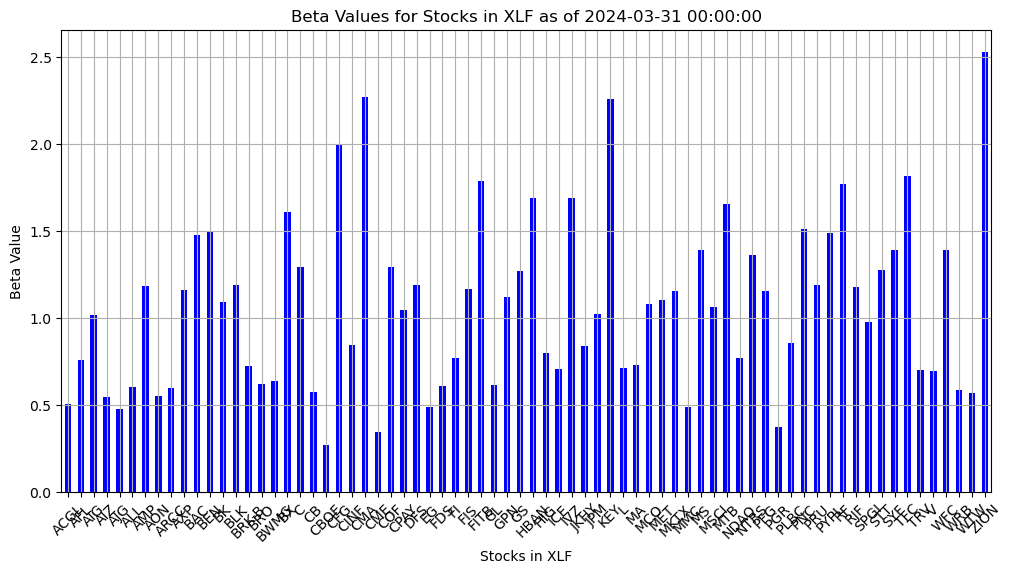

In [7]:
xlf_ticker = 'XLF'
betas_per_day = {}
df = holdings_per_day[xlf_ticker]
betas_per_day[xlf_ticker] = pd.DataFrame({stock: betas(stock, xlf_ticker, start_date, end_date) * df[stock] for stock in df.columns})

latest_date = betas_per_day[xlf_ticker].index[-1]
beta_values = betas_per_day[xlf_ticker].loc[latest_date].dropna()

plt.figure(figsize=(12, 6))
beta_values.plot(kind='bar', color='blue')
plt.xlabel('Stocks in XLF')
plt.ylabel('Beta Value')
plt.title(f'Beta Values for Stocks in XLF as of {latest_date}')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

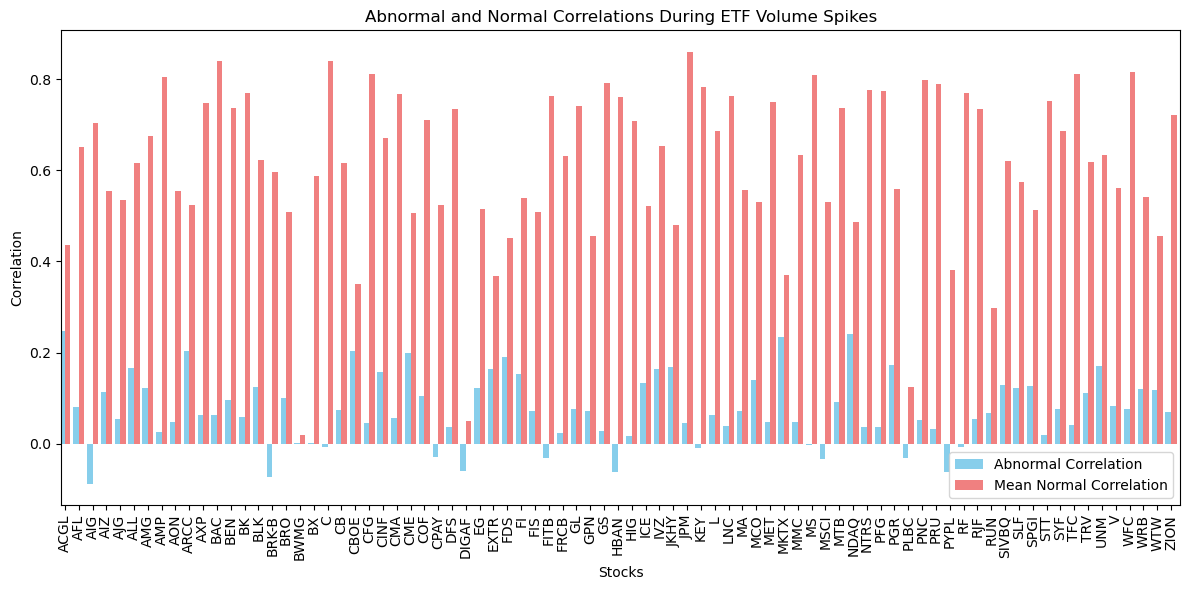

In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

days_in_quarter = 63

def volume_spikes(etf_ticker, threshold=2):
    data = yf.Ticker(etf_ticker).history(period='max')
    volume = data['Volume']
    mean_volume = volume.mean()
    std_volume = volume.std()
    
    spikes = volume[volume > mean_volume + threshold * std_volume]
    return spikes.index

def returns(ticker):
    data = yf.Ticker(ticker).history(period='max')
    returns = (data['Close'] - data['Close'].shift(1)) / data['Close'].shift(1)
    return returns.dropna()

def rolling_correlations(stock_ticker, etf_ticker, window=63):
    stock_returns = returns(stock_ticker)
    etf_returns = returns(etf_ticker)
    
    combined_data = pd.DataFrame({
        stock_ticker: stock_returns,
        etf_ticker: etf_returns
    }).dropna()
    
    rolling_corr = combined_data[stock_ticker].rolling(window).corr(combined_data[etf_ticker])
    return rolling_corr

def abnormal_correlations(stock_ticker, etf_ticker, window=63, threshold=2):
    rolling_corr = rolling_correlations(stock_ticker, etf_ticker, window)
    spikes = volume_spikes(etf_ticker, threshold)
    
    normal_corr = rolling_corr[~rolling_corr.index.isin(spikes)]
    mean_normal_corr = normal_corr.mean()

    spike_corr = rolling_corr[rolling_corr.index.isin(spikes)]
    mean_spike_corr = spike_corr.mean()
    
    return mean_spike_corr - mean_normal_corr, mean_normal_corr, mean_spike_corr

etf_ticker = 'XLF'
stock_tickers = ['ACGL', 'AFL', 'AIG', 'AIZ', 'AJG', 'ALL', 'AMG', 'AMP', 'AON', 'ARCC',
       'AXP', 'BAC', 'BEN', 'BK', 'BLK', 'BRK-B', 'BRO', 'BWMG', 'BX', 'C',
       'CB', 'CBOE', 'CFG', 'CINF', 'CMA', 'CME', 'COF', 'CPAY', 'DFS',
       'DIGAF', 'EG', 'EXTR', 'FDS', 'FI', 'FIS', 'FITB', 'FRCB', 'GL', 'GPN',
       'GS', 'HBAN', 'HIG', 'ICE', 'IVZ', 'JKHY', 'JPM', 'KEY', 'L', 'LNC',
       'MA', 'MCO', 'MET', 'MKTX', 'MMC', 'MS', 'MSCI', 'MTB', 'NDAQ', 'NTRS',
       'PFG', 'PGR', 'PLBC', 'PNC', 'PRU', 'PYPL', 'RF', 'RJF', 'RUN', 'SIVBQ',
       'SLF', 'SPGI', 'STT', 'SYF', 'TFC', 'TRV', 'UNM', 'V', 'WFC', 'WRB',
       'WTW', 'ZION']  
abnormal_corr_results = {}

for stock in stock_tickers:
    abnormal_corr, mean_normal_corr, mean_spike_corr = abnormal_correlations(stock, etf_ticker)
    abnormal_corr_results[stock] = {
        'abnormal_corr': abnormal_corr,
        'mean_normal_corr': mean_normal_corr,
        'mean_spike_corr': mean_spike_corr
    }

abnormal_corr_df = pd.DataFrame.from_dict(abnormal_corr_results, orient='index')

fig, ax = plt.subplots(figsize=(12, 6))

abnormal_corr_df['abnormal_corr'].plot(kind='bar', color='skyblue', ax=ax, position=1, width=0.4, label='Abnormal Correlation')

abnormal_corr_df['mean_normal_corr'].plot(kind='bar', color='lightcoral', ax=ax, position=0, width=0.4, label='Mean Normal Correlation')

plt.title('Abnormal and Normal Correlations During ETF Volume Spikes')
plt.xlabel('Stocks')
plt.ylabel('Correlation')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()
